## Supervised Learning using k-Nearest Neighbours

### Recognise characters from google street view images

This demo extends the kaggle [competition](https://www.kaggle.com/c/street-view-getting-started-with-julia/details/julia-tutorial). In this demo, we train using images of characters obtained from google view, and also classify test images which are of various sizes. Firstly k-Nearest Neighbor is used to identify the characters. 

#### Some key takeaways:
* Ease of prototyping deployable models. 
* How to gain from vectorizations using **ArrayFire**.

The following data has been placed in the /data directory

* testResized/
* trainResized/
* sampleSubmission.csv
* trainLabels.csv

First, let's load all the packages we need.

The related blogpost is [here](http://juliacomputing.com/blog/2016/09/28/knn-char-recognition.html).

** Credits ** :

[kaggle competition - Julia tutorial](https://www.kaggle.com/c/street-view-getting-started-with-julia/details/julia-tutorial)

[Dataset](https://www.kaggle.com/c/street-view-getting-started-with-julia/data)

In this tutorial, we use Julia to implement the K-Nearest Neighbor (k-NN) algorithm with Leave-One-Out-Fold Cross Validation (LOOF-CV). 

k-NN and LOOF-CV are available in many standard machine learning libraries, but they do not take the advantage of the fact that LOOF-CV is particularly fast with k-NN. Here we customize the implementation to use this property and efficiently tune the parameter k, the number of neighbors. 

For cases where a custom implementation is necessary, Julia is an attractive language choice because prototypes can be easily written and the language is fast without needing external code. This tutorial also introduces parallelization in Julia, which allows us to speed up the program. Parallelization is not unique to Julia, but Julia is designed such that it is remarkably easy implement. 

Set a few paths:
* The Datapath
* Image sizes: we're going to be working with images of sizes 20x20. You might see them as vectors of 400 though, but more on that later.

In [41]:
path = joinpath(pwd(),"characters")
imageSize = 400

400

In [42]:
using DataFrames
using Gadfly
using Images
using Interact
using Colors

## Training

First, read the training labels! Now, there are two columns, `ID` and `Class`. `ID` represents the picture `ID.Bmp`, and `Class` represents the _correct_ classification. We're going to use this to train our model.  

In [43]:
trainLabels = readtable("$(path)/trainLabels.csv")
trainLabels = trainLabels[1:1000,:]

,ID,Class
1,1,n
2,2,8
3,3,T
4,4,I
5,5,R
6,6,W
7,7,L
8,8,l
9,9,K
10,10,G


In [8]:
trainLabels = readtable("$(path)/trainLabels.csv")
trainLabels = trainLabels[1:1000,:]

,ID,Class
1,1,n
2,2,8
3,3,T
4,4,I
5,5,R
6,6,W
7,7,L
8,8,l
9,9,K
10,10,G


What's the size of our training set?

In [44]:
size(trainLabels)

(1000, 2)

Let us now examine our training set's contents. Run the following code to generate a histogram of the data.

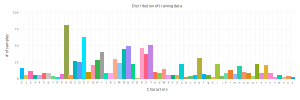

In [5]:
counts=by(trainLabels, :Class, nrow);
p1=Gadfly.plot(x = counts[:Class], y=counts[:x1], color = counts[:Class], Theme(key_position = :none), Guide.xlabel("Characters"), Guide.ylabel("# of samples"), Geom.bar, Guide.title("Distribution of training data"))
draw(SVG(30cm, 10cm), p1)

You can also scroll through the images!

Interact.Options{:SelectionSlider,Any}(1: "input" = 500 Any , "i", 500, "500", 500, Interact.OptionDict(DataStructures.OrderedDict{Any,Any}("1"=>1,"2"=>2,"3"=>3,"4"=>4,"5"=>5,"6"=>6,"7"=>7,"8"=>8,"9"=>9,"10"=>10…), Dict{Any,Any}(Pair{Any,Any}(306, "306"),Pair{Any,Any}(29, "29"),Pair{Any,Any}(74, "74"),Pair{Any,Any}(905, "905"),Pair{Any,Any}(176, "176"),Pair{Any,Any}(892, "892"),Pair{Any,Any}(285, "285"),Pair{Any,Any}(318, "318"),Pair{Any,Any}(873, "873"),Pair{Any,Any}(975, "975")…)), Any[], Any[], true, "horizontal")

INFO: Recompiling stale cache file /Applications/JuliaPro-0.6.2.2.app/Contents/Resources/pkgs-0.6.2.2/lib/v0.6/QuartzImageIO.ji for module QuartzImageIO.


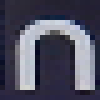

In [5]:
@manipulate for i = 1:size(trainLabels,1)
    load("$(path)/trainResized/$i.Bmp")
end

In [8]:
trainLabels[500,2]

"n"

But we haven't really read the training data yet. Only the labels. 

Now, load each image, convert into grayscale, and build a large training data matrix. Each row represents an image

In [10]:
function read_data_sv(typeData::AbstractString, trainLabels::DataFrame, imageSize)
    x = zeros(size(trainLabels, 1), imageSize)
    for (index, idImage) in enumerate(trainLabels[:ID])
    nameFile = "$(path)/$(typeData)Resized/$(idImage).Bmp"
        img = load(nameFile)
        img = Gray.(img)
        x[index, :] = reshape(img, 1, imageSize)
    end
    x
end
train_data = read_data_sv("train", trainLabels, imageSize)

1000×400 Array{Float64,2}:
 0.243137   0.25098    0.254902   …  0.262745   0.262745   0.278431 
 0.462745   0.458824   0.462745      0.45098    0.454902   0.454902 
 0.317647   0.321569   0.286275      0.321569   0.301961   0.305882 
 0.301961   0.317647   0.439216      0.443137   0.521569   0.54902  
 0.0862745  0.0705882  0.0784314     0.0862745  0.0823529  0.0745098
 0.419608   0.419608   0.419608   …  0.431373   0.423529   0.415686 
 0.286275   0.290196   0.278431      0.298039   0.278431   0.282353 
 0.243137   0.203922   0.235294      0.27451    0.286275   0.254902 
 0.247059   0.239216   0.243137      0.227451   0.25098    0.235294 
 0.784314   0.819608   0.847059      0.941176   0.941176   0.945098 
 0.364706   0.364706   0.352941   …  0.458824   0.458824   0.45098  
 0.266667   0.27451    0.282353      0.333333   0.254902   0.262745 
 0.235294   0.670588   0.745098      0.196078   0.133333   0.117647 
 ⋮                                ⋱                                 
 0.2901

## Tempering the Data

All the labels are strings. Let's convert them into character labels and then convert to integer labels. 

In [12]:
names(trainLabels)

2-element Array{Symbol,1}:
 :ID   
 :Class

In [11]:
chars = map(x -> x[1], trainLabels[:Class])
trainLabelsInt = map(Int, chars) 
trainLabelsInt = Array(trainLabelsInt)

1000-element Array{Int64,1}:
 110
  56
  84
  73
  82
  87
  76
 108
  75
  71
  65
  65
  67
   ⋮
  84
  52
  48
  79
  79
 101
  71
  74
 101
  78
 101
  69

Transpose the images, so that the columns represent each image. Note that every entry in the our training labels corresponds to a column in this matrix. For example, the first label is an 'n', and so is the first image. Scroll back up and check that the training labels match the images. 

In [13]:
train_data = train_data'

400×1000 Array{Float64,2}:
 0.243137  0.462745  0.317647  0.301961  …  0.294118  0.65098   0.862745
 0.25098   0.458824  0.321569  0.317647     0.443137  0.666667  0.917647
 0.254902  0.462745  0.286275  0.439216     0.431373  0.513725  0.776471
 0.25098   0.466667  0.27451   0.560784     0.415686  0.478431  0.894118
 0.219608  0.466667  0.298039  0.615686     0.419608  0.643137  0.909804
 0.623529  0.462745  0.309804  0.6       …  0.478431  0.67451   0.894118
 0.266667  0.572549  0.298039  0.572549     0.501961  0.654902  0.894118
 0.258824  0.831373  0.32549   0.556863     0.470588  0.643137  0.87451 
 0.254902  0.8       0.384314  0.556863     0.435294  0.662745  0.894118
 0.247059  0.811765  0.576471  0.556863     0.419608  0.654902  0.882353
 0.247059  0.823529  0.690196  0.560784  …  0.392157  0.67451   0.858824
 0.239216  0.741176  0.729412  0.556863     0.419608  0.670588  0.862745
 0.258824  0.811765  0.709804  0.560784     0.427451  0.666667  0.886275
 ⋮                      

## The Algorithm

The algorithm we're using here is a very simple, rudimentary K nearest neighbors (KNN). The idea is to take a particular image, and see which "k" images it is closest to. 

** Objective ** : To find the right value of "k" such that our model matches the training set.

Some questions: 
* What does "closest" mean? How do you measure distance between two images?
* How exactly do you find the right value of "k"?
* What exactly is our "model"?

The following function takes a particular image and finds the distance between the image under consideration and all the others. Note that each image is now a vector of 400 instead of the original 20x20, making it simpler to calculate distances.

In [17]:
function get_all_distances(imageI::AbstractArray, x::AbstractArray)
    diff = imageI .- x
    distances = vec(sum(diff .* diff,1))
end

get_all_distances (generic function with 1 method)

Find the "k" closest neighbors. Once you get all the distances, consider the first "k" distances as your closest distances. (Why do you thinking we're taking `2:k+1` instead of `1:k` ?)

In [18]:
function get_k_nearest_neighbors(x::AbstractArray, imageI::AbstractArray, k::Int = 3, train = true)
    nRows, nCols = size(x)
    distances = get_all_distances(imageI, x)
    sortedNeighbors = sortperm(distances)
    if train
        return kNearestNeighbors = Array(sortedNeighbors[2:k+1])
    else
        return kNearestNeighbors = Array(sortedNeighbors[1:k])  
    end
end


get_k_nearest_neighbors (generic function with 3 methods)

Finally, assign the most "popular" character amongst the "k" least distances to the image under question. 

In [20]:
function assign_label(x::AbstractArray, y::AbstractArray{Int64}, imageI::AbstractArray, k, train::Bool)
    kNearestNeighbors = get_k_nearest_neighbors(x, imageI, k, train)
    counts = Dict{Int, Int}()
    highestCount = 0
    mostPopularLabel = 0
    for n in kNearestNeighbors
        labelOfN = y[n]
        if !haskey(counts, labelOfN)
            counts[labelOfN] = 0
        end
        counts[labelOfN] += 1
        if counts[labelOfN] > highestCount
            highestCount = counts[labelOfN]
            mostPopularLabel = labelOfN
        end
     end
    mostPopularLabel
end

assign_label (generic function with 1 method)

Let's run this now. What's the training accuracy? 

Make this better:
* More training samples
* A better model! 


In [21]:
k = 3
checks = falses(size(train_data, 2))
@time for i = 1:size(train_data, 2)
    imageI = train_data[:,i]
    checks[i]  = (assign_label(train_data, trainLabelsInt, imageI, k, true) == trainLabelsInt[i])
end
accuracy = length(find(checks)) / length(checks)

  3.482764 seconds (239.54 k allocations: 5.990 GiB, 23.18% gc time)


0.26

In [31]:
size(train_data)

(400, 1000)

## Test cases

Let's read the test labels now. 

In [22]:
testLabels = readtable("$(path)/testLabels.csv")
testLabels = testLabels[1:1000,:]

,ID,Class
1,6284,A
2,6285,A
3,6286,A
4,6287,A
5,6288,A
6,6289,A
7,6290,A
8,6291,A
9,6292,A
10,6293,A


Read the test data. We're going to take every test image and then find which training image it is closest to, and then assign it to that particular class. 

In [23]:
test_data = read_data_sv("test", testLabels, imageSize)

1000×400 Array{Float64,2}:
 0.45098    0.439216   0.443137   …  0.898039   0.627451  0.470588 
 0.282353   0.27451    0.278431      0.380392   0.317647  0.294118 
 0.113725   0.117647   0.0980392     0.188235   0.109804  0.101961 
 0.592157   0.592157   0.584314      0.596078   0.584314  0.592157 
 0.501961   0.490196   0.509804      0.152941   0.439216  0.541176 
 0.552941   0.552941   0.54902    …  0.337255   0.305882  0.501961 
 0.141176   0.145098   0.137255      0.137255   0.152941  0.156863 
 0.862745   0.862745   0.870588      0.890196   0.898039  0.882353 
 0.705882   0.709804   0.709804      0.756863   0.733333  0.701961 
 0.866667   0.858824   0.858824      0.176471   0.305882  0.905882 
 0.231373   0.317647   0.4        …  0.235294   0.243137  0.239216 
 0.737255   0.780392   0.780392      0.780392   0.780392  0.780392 
 0.47451    0.47451    0.482353      0.478431   0.466667  0.478431 
 ⋮                                ⋱                                
 0.72549    0.72549  

In [24]:
test_data = test_data'

400×1000 Array{Float64,2}:
 0.45098   0.282353  0.113725   0.592157  …  0.305882  0.564706   0.490196
 0.439216  0.27451   0.117647   0.592157     0.32549   0.556863   0.227451
 0.443137  0.278431  0.0980392  0.584314     0.317647  0.572549   0.396078
 0.439216  0.290196  0.0901961  0.6          0.337255  0.6        0.552941
 0.447059  0.329412  0.105882   0.572549     0.301961  0.372549   0.517647
 0.45098   0.356863  0.101961   0.576471  …  0.309804  0.160784   0.509804
 0.447059  0.380392  0.0901961  0.611765     0.317647  0.117647   0.509804
 0.443137  0.372549  0.0980392  0.596078     0.34902   0.113725   0.52549 
 0.439216  0.286275  0.0901961  0.596078     0.372549  0.133333   0.537255
 0.439216  0.266667  0.117647   0.596078     0.223529  0.0941176  0.54902 
 0.45098   0.27451   0.117647   0.603922  …  0.45098   0.0627451  0.556863
 0.439216  0.278431  0.0862745  0.6          0.54902   0.121569   0.54902 
 0.45098   0.278431  0.0901961  0.592157     0.529412  0.180392   0.54509

Let's now run our test data and get our predictions. 

In [26]:
x = test_data
xT = train_data
yT = trainLabelsInt
k = 3
prediction = zeros(Int,size(x,2))
@time for i = 1:size(x,2)
    imageI = x[:,i]
    prediction[i]  = assign_label(xT, yT, imageI, k, false)
end

  3.040153 seconds (19.98 k allocations: 5.980 GiB, 26.71% gc time)


In [27]:
prediction = map(Char, prediction)

1000-element Array{Char,1}:
 'P'
 'A'
 'r'
 'I'
 'E'
 'I'
 'g'
 'I'
 '6'
 'R'
 'N'
 'R'
 'N'
 ⋮  
 'R'
 'R'
 'R'
 'N'
 'i'
 'E'
 'R'
 'l'
 't'
 'm'
 'A'
 'T'

Interact.Options{:SelectionSlider,Any}(5: "input-2" = 500 Any , "i", 500, "500", 500, Interact.OptionDict(DataStructures.OrderedDict{Any,Any}("1"=>1,"2"=>2,"3"=>3,"4"=>4,"5"=>5,"6"=>6,"7"=>7,"8"=>8,"9"=>9,"10"=>10…), Dict{Any,Any}(Pair{Any,Any}(306, "306"),Pair{Any,Any}(29, "29"),Pair{Any,Any}(74, "74"),Pair{Any,Any}(905, "905"),Pair{Any,Any}(176, "176"),Pair{Any,Any}(892, "892"),Pair{Any,Any}(285, "285"),Pair{Any,Any}(318, "318"),Pair{Any,Any}(873, "873"),Pair{Any,Any}(975, "975")…)), Any[], Any[], true, "horizontal")

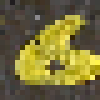

In [28]:
@manipulate for i = 1:1000
    load("$path/testResized/$(6283+i).Bmp")
end

In [46]:
i = 539
prediction[i]

'S': ASCII/Unicode U+0053 (category Lu: Letter, uppercase)

In [40]:
# 539, 537, 638, 745, 616

# 722, 